## <font color='blue'>Introduction</font>

#### In the first case study, we cover the basic structures and procedures to run simulation with DARTS. 
#### DARTS contains two main modules: 
* <font color='red'>engines</font>  
* <font color='red'>physics</font> 
    
#### These modules are programmed in C++ and exposed to python with compiled packages (libraries) named as
* <font color='red'>engines.pyd</font>
* <font color='red'>physics.pyd</font>

  
#### Module engines.pyd provides the run-simulation needed functionalities, like
* reservoir (mesh) initialization
* well settings
* interpolation operation
* jacobian assembly
* linear and nonlinear iteration

#### Module physics.pyd provides the property-calculation needed functionalities, like
* water/steam properties
* operator values

#### Both of them could be found in the folder <font color='red'>'darts'</font>.

## <font color='blue'>The objectives for the first exercise</font>
1. Be familiar with the basic procedures to run a simulation
2. Exercise on several simulation parameters including timestep controls and mesh 

## Geothermal physics used in DARTS

<img style="float: left;" src="slides/Slide2.JPG" width="60%">

<img style="float: left;" src="slides/Slide3.JPG" width="60%">

<img style="float: left;" src="slides/Slide4.JPG" width="60%">

<img style="float: left;" src="slides/Slide5.JPG" width="60%">

## 1D Model can be divided into following parts:
<img style="float: left;" src="slides/Slide7.JPG" width="60%">

## <font color='blue'>Let's start !</font>
### Step 1. We need to import <font color='red'>engines</font> and  <font color='red'>physics</font> into the workspace, just like the import of commonly-used modules such as numpy, matplotlib, scipy etc.

In [1]:
from darts.models.physics.geothermal import Geothermal
from darts.models.physics.iapws.iapws_property import *
from darts.engines import *
import numpy as np

### Step 2. We need to specify the time recorder, which could help to make sure about the performance of the simulator in different parts. Timers can be created in hierachical order.

In [2]:
# Call class constructor and Build timer_node object
timer = timer_node()

# Call object members; there are 2 types of members:
## <1>Function member:
timer.start()
## <2>Data member:
timer.node["simulation"] = timer_node()
timer.node["initialization"] = timer_node()

# Start initialization
timer.node["initialization"].start()

### Step 3. Simulation parameters setting. This section specifies the simulation parameters, which will control, for example:

* timestep strategy (first_ts, max_ts, mult_ts)
* convergence criteria (tolerance of nonlinear iteration and other parameters controlling iterations)

In [3]:
# Build a sim_params object by calling constructor
params = sim_params()

# Adjust time step settings
# First time step (time unit: day)
params.first_ts = 0.01

# Time step multiplier
params.mult_ts = 4

# Maximum time step
params.max_ts = 1

# Newton tolerance
params.tolerance_newton = 1e-5

### Step 4. Mesh initialization
<img style="float: left;" src="slides/Slide12.JPG" width="60%">

In [4]:
'''Mesh initialization for 1D reservoir with constant transmissibility'''
# Create mesh object by calling the class constructor
mesh = conn_mesh()

# Set grid block (mesh) number
nb = 30 * 10

# Create connection list for 1D reservoir 
block_m = np.arange(nb - 1)
block_p = block_m + 1

# Set constant transmissbility
permeability = 2
tranD = np.ones(nb - 1) * 0.1 * 10
tran = tranD * permeability

# Initialize mesh with connection list
mesh.init(index_vector(block_m), index_vector(block_p),
          value_vector(tran), value_vector(tranD))

# Complete mesh initialization
mesh.reverse_and_sort()

0

### Step 5. Define properties
* connecting numpy arrays to the mesh
* fill porosity, depth, volume, conduction and heat capacity
* imitate boundary conditions with large volumes

In [5]:
# Create numpy arrays wrapped around mesh data (no copying)
volume = np.array(mesh.volume, copy=False)
porosity = np.array(mesh.poro, copy=False)
depth = np.array(mesh.depth, copy=False)

# Thermal properties
hcap = np.array(mesh.heat_capacity, copy=False)
cond = np.array(mesh.rock_cond, copy=False)

# Assign volume, porosity and depth values
volume.fill(300 / 10)
porosity.fill(0.2)
depth.fill(1000)

# Assign thermal properties
hcap.fill(2200)
cond.fill(230 * 100)

# Make first and last blocks large (source/sink)
volume[0] = 1e10
volume[nb-1] = 1e10

### Step 6. Boundary and initial conditions
* initial reservoir conditions
* pressure source and sink
* translation from temperature to enthalpy

In [6]:
# Create numpy wrappers for initial solution
pressure = np.array(mesh.pressure, copy=False) 
enthalpy =  np.array(mesh.enthalpy, copy=False)

# Assign initial pressure values
pressure.fill(200)
pressure[0] = 250
pressure[nb-1] = 150

# Assign enthalpy values:
# first, define initial temperature (Kelvin) ...
temp = 348 * np.ones(nb)
temp[0] = 308

# then, convert temperature to initial enthalpy (kJ/kg)
for i in range(0, len(temp)):   
    state = value_vector([pressure[i], 0])
    E = iapws_total_enthalpy_evalutor(temp[i])
    enthalpy[i] = E.evaluate(state)

### Step 7. Physics initialization
* translate temperature range to enthalpy
* initialize physical ranges

In [7]:
# Define function to calculate enthalpy range corresponding to given pressure and temperature ranges
def calc_enthalpy_range(pres, temp):
    min_e = 1e5
    max_e = 0
    for i in range(len(pres)):
        for j in range(len(pres)):
            state = value_vector([pres[i], 0])
            E = iapws_total_enthalpy_evalutor(temp[i])
            enth = E.evaluate(state)
            if min_e > enth:
                min_e = enth
            if max_e < enth:
                max_e = enth
    return min_e, max_e

# Define pressure and temeprature ranges for the problem
min_p = 1
max_p = 351
min_T = 273.15
max_T = 500

# Evaluate enthalpy range
min_e, max_e  = calc_enthalpy_range([min_p, max_p], [min_T, max_T]) 

# Define amount of points for OBL 
n_points = 64

# Build physics class; the format of constructor:
# Geothermal(timer, n_points, min_pres, max_pres, min_enth, max_enth)
physics = Geothermal(timer, n_points, min_p, max_p, min_e, max_e)

### Step 8. Engine initialization and run
<img style="float: left;" src="slides/Slide16.JPG" width="60%">

In [8]:
# Initialize engine
physics.engine.init(mesh, ms_well_vector(),
                    op_vector([physics.acc_flux_itor]),
                    params, timer.node["simulation"])

# Stop initialization timer
timer.node["initialization"].stop()

# Run simulator for 2000 days
physics.engine.run(2000)

# Print timers (note where most of the time was spent!)
print(timer.print("", ""))

Total elapsed 12.964000 sec
	initialization 0.734000 sec
	simulation 12.228000 sec
		jacobian assembly 5.128000 sec
			interpolation 4.747000 sec
				acc flux interpolation 5.014000 sec
					body generation 4.546000 sec
						point generation 4.542000 sec
				rate interpolation 0.000000 sec
		linear solver setup 0.803000 sec
			GMRES 0.791000 sec
				CPR 0.774000 sec
					AMG 0.563000 sec
					ILU(0) 0.136000 sec
		linear solver solve 0.527000 sec
			GMRES 0.522000 sec
				CPR 0.410000 sec
					AMG 0.210000 sec
					ILU(0) 0.107000 sec
		newton update 0.020000 sec
			composition correction 0.005000 sec



### Step 9. Data processing and plots

In [9]:
# Define function to convert enthalpy to temperature
def enthalpy_to_temperature(pres, enth):
    state = value_vector([0, 0])
    temp = np.zeros(len(pres))
    T = iapws_temperature_evaluator()
    for i in range(len(pres)):
        state[0] = pres[i]
        state[1] = enth[i]
        temp[i] = T.evaluate(state)
    return temp

In [10]:
# Define function to plot arbitrary data profile
%matplotlib inline
def plot_profile(data, name, sp, ax):
    n = len(data)    
    ax.plot(np.arange(n), data[0:n], 'ro')
    ax.set_xlabel('Grid index')
    ax.set_ylabel('%s' % (name))
    #ax.xlim([0, n])

In [11]:
# Get numpy wrapper for final solution
X = np.array(physics.engine.X, copy=False)

# Prepare for plotting
import matplotlib.pyplot as plt
fig = plt.figure()    

<Figure size 432x288 with 0 Axes>

In [12]:
def plot_solution(X):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Plot pressure profile
    plot_profile(X[0:2*nb:2],'Pressure, bar',1,axes[0])
    # Convert enthalpy to temperature first before plotting
    temp = enthalpy_to_temperature(X[0::2], X[1::2])
    # Plot temperature profile
    plot_profile(temp[0:nb]-273.15,'Temperature, C',2,axes[1])

#### Solution of problem - blockwise array: $[\{p_1,h_1\},\{p_2,h_2\},\ldots,\{p_n,h_n\}]$


<img style="float: left;" src="slides/Slide19.JPG" width="60%">

In [13]:
# plot_solution(X)

<img style="float: left;" src="slides/Slide20.JPG" width="60%">

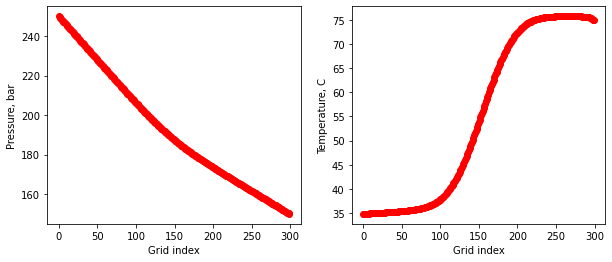

In [14]:
plot_solution(X)

<img style="float: left;" src="slides/Slide21.JPG" width="60%">

In [15]:
# plot_solution(X)

<img style="float: left;" src="slides/Slide22.JPG" width="60%">

In [16]:
# plot_solution(X)

<img style="float: left;" src="slides/Slide23.JPG" width="60%">

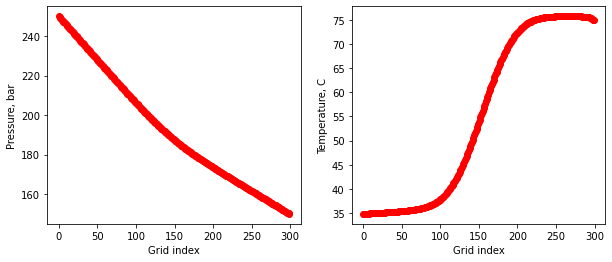

In [17]:
plot_solution(X)